<a href="https://colab.research.google.com/github/AanchalA/PyTorch-Deep-Learning-Bootcamp/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1456), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Getting Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# Model Deployment - Experiment Outline

1. What is the most ideal ML Model deployment scenarion?
- A model that performs well and fast
    - Performs well: 95%+ Accuracy
    - Fast: As close to real-time (or faster) as possible (30FPS+ or 30ms Latency)
---

2. Where is my model going to go?
- On Device (Deployment with Google ML-Kit, Apple CoreML)
- Cloud (Deployment with Google VertexAI, AWS SageMaker, HuggingFace Spaces, Azure Machine Learning)
- APIs (Deployment with FastAPI, TorchServe, ONNX - Open Neural Network Exchange)

---
3. How is my model going to function?
- Online (Real-Time)
- Offline (Batch Processing)

---
---

Experiments:

1. EffNetB2 (07. PyTorch Experiment Tracking)
2. ViT (08. PyTorch Paper Replicating)

# EfficientNetB2

## Creating An EffNetB2 Feature Extractor

In [ ]:
import torchvision

In [ ]:
def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):

    # Setting up the pre-trained EFfNetB2 Weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

    # Get EffNetB2 Transforms
    effnetb2_transforms =  effnetb2_weights.transforms()

    # Setting up the pre-trained model instance
    effnetb2_pretrained = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

    # Freezing the base layers in the model
    for param in effnetb2_pretrained.parameters():
        param.requires_grad = False

    # Changing the classifier head to output the desiered number of classes
    # set_seeds()
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    effnetb2_pretrained.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )


    return effnetb2_pretrained, effnetb2_transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 46.4MB/s]


In [ ]:
# # Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

## DataLoaders for EffNetB2

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), len(class_names)

(15, 5, 3)

## Training EffNetB2 Model

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


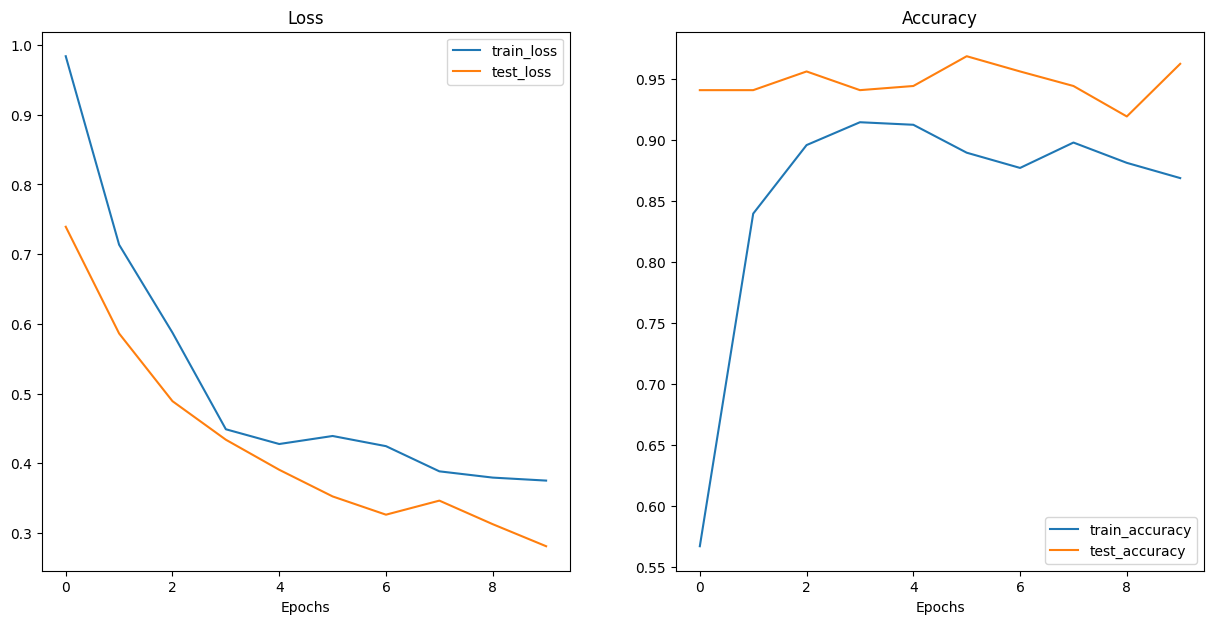

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## Inspecting the Size of the EffNetB2 Feature Extractor Model

In [ ]:
from pathlib import Path

effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 *1024)
print(f"EffNetB2 Model Size: {effnetb2_model_size: .2f} MB")

EffNetB2 Model Size:  29.86 MB


## Counting the Number of Parameters in EffNetB2 Model

In [ ]:
effnetb2_num_parameters = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"EffNetB2 Number of Parameters: {effnetb2_num_parameters}")

EffNetB2 Number of Parameters: 7705221


## Creating A Dict with EffNetB2 Stats

In [ ]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_num_parameters,
                  "model_size (MB)": effnetb2_model_size}

# Vision Transformer Model

## Creating the ViT Feature Extractor

In [ ]:
def create_vit_feature_extractor(num_classes: int=3,
                                 seed: int=42):
    vitb16_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vitb16_transforms = vitb16_weights.transforms()
    vitb16_pretrained = torchvision.models.vit_b_16(weights=vitb16_weights)

    for param in vitb16_pretrained.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    vitb16_pretrained.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes, bias=True)
    )

    return vitb16_pretrained, vitb16_transforms

In [ ]:
vit, vit_transforms = create_vit_feature_extractor()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 73.5MB/s]


In [ ]:
# # Print ViT model summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


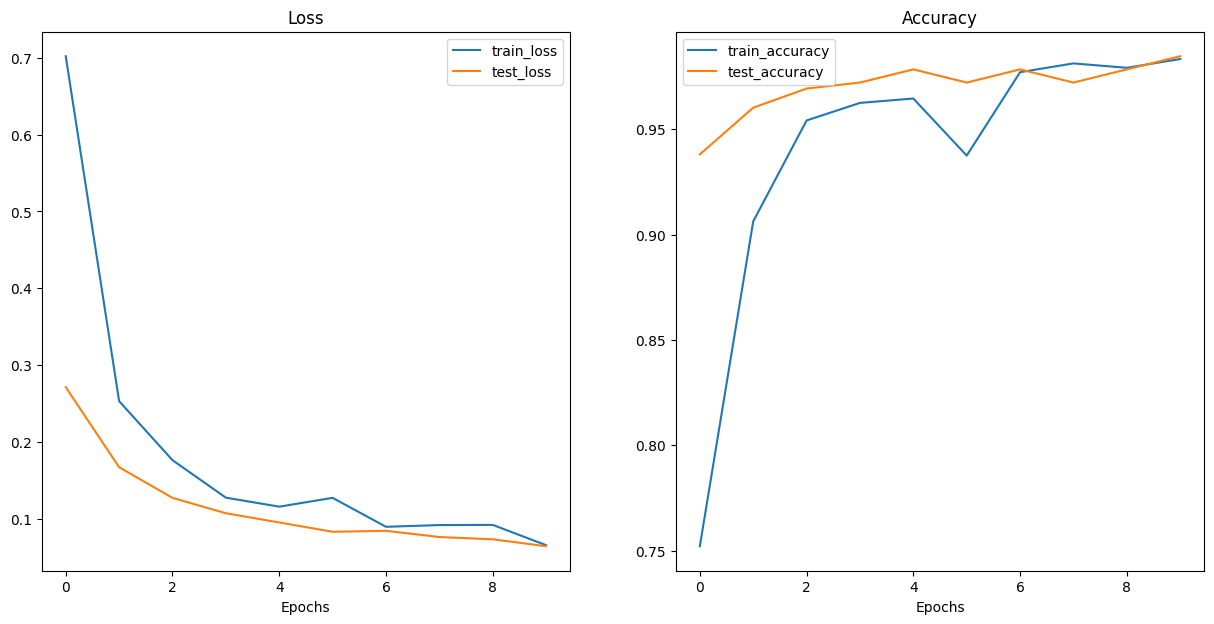

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024* 1024)
print(f"ViT Model Size: {vit_model_size: .2f} MB")

ViT Model Size:  327.37 MB


In [ ]:
vit_num_params = sum(torch.numel(param) for param in vit.parameters())
print(f"ViT Number of Parameters: {vit_num_params}")

ViT Number of Parameters: 85800963


In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_num_params,
             "model_size (MB)": vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887}

# Makig Predictions with the Trained Models and Timing Them

Goal - 95%+ Acc AND 30+ FPS



In [ ]:
import pathlib
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List
from timeit import default_timer as timer

In [ ]:
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/864661.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/552171.jpg')]

In [ ]:
def pred_and_store(test_data_paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transforms: torchvision.transforms,
                   class_names: list[str],
                   device: torch.device=device) -> List[Dict]:

    results = list()

    for image_path in tqdm(test_data_paths):
        ground_truth_class = image_path.parent.stem

        start_time = timer()

        image = Image.open(image_path)
        transformed_image = transforms(image).unsqueeze(dim=0).to(device)          ## Adding the batch dim

        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            logits = model(transformed_image)
            pred_probs = torch.softmax(logits, dim=1)
            pred_class = class_names[logits.argmax(dim=1).cpu()]

        end_time = timer()
        image_result = {"image_path": image_path,
                        "class_name": ground_truth_class,
                        "pred_prob": round(pred_probs.unsqueeze(0).max().cpu().item(), 4),
                        "pred_class": pred_class,
                        "time_for_pred": round(end_time - start_time, 4),
                        "correct": ground_truth_class == pred_class}
        results.append(image_result)


    return results

## Predictions with EffNetB2

In [ ]:
effnet_b2_test_preds = pred_and_store(test_data_paths=test_data_paths,
                                        model=effnetb2,
                                        transforms=effnetb2_transforms,
                                        class_names=class_names,
                                      device=torch.device("cpu"))

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnet_b2_test_preds_df = pd.DataFrame(effnet_b2_test_preds)
effnet_b2_test_preds_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6540,steak,0.3815,True
1,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9469,steak,0.1206,True
2,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9056,steak,0.1062,True
3,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.4196,steak,0.1017,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9231,steak,0.1104,True


In [ ]:
effnet_b2_test_preds_df.correct.value_counts(normalize=True)

,proportion
correct,
True,0.96
False,0.04


In [ ]:
# Find Avg. time per prediction
avg_time_per_pred = round(effnet_b2_test_preds_df.time_for_pred.mean(), 4)
effnetb2_stats["avg_time_per_pred"] = avg_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'avg_time_per_pred': 0.1241}

## Predictions with ViT

In [ ]:
vit_test_preds = pred_and_store(test_data_paths=test_data_paths,
                                        model=vit,
                                        transforms=vit_transforms,
                                        class_names=class_names,
                                      device=torch.device("cpu"))

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_preds_df = pd.DataFrame(vit_test_preds)
vit_test_preds_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.8396,True
1,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9916,steak,0.5413,True
2,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,0.5297,True
3,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9630,steak,0.6605,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9123,steak,0.8843,True


In [ ]:
vit_test_preds_df.correct.value_counts(normalize=True)

,proportion
correct,
True,0.986667
False,0.013333


In [ ]:
# Find Avg. time per prediction
avg_time_per_pred = round(vit_test_preds_df.time_for_pred.mean(), 4)
vit_stats["avg_time_per_pred"] = avg_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37096977233887,
 'avg_time_per_pred': 0.6119}

# Model Comparison

In [ ]:
stats_df = pd.DataFrame([effnetb2_stats, vit_stats])
stats_df['model'] = ["EffNetB2", "ViT"]
stats_df['test_acc'] = round(stats_df['test_acc'] * 100, 2)

stats_df

,test_loss,test_acc,number_of_parameters,model_size (MB),avg_time_per_pred,model
0,0.281087,96.25,7705221,29.863886,0.1241,EffNetB2
1,0.064435,98.47,85800963,327.370970,0.6119,ViT


## Comapre ViT to EffNetB2 accross differenct characteristics. Calculating the ratios for each of them.

In [ ]:
pd.DataFrame(data=(stats_df.set_index("model").loc["ViT"] / stats_df.set_index("model").loc["EffNetB2"]),
             columns=["ViT/EffNetB2 Ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),avg_time_per_pred
ViT/EffNetB2 Ratios,0.229233,1.023065,11.135432,10.962102,4.930701


## Visualizing the Speed V/s Performance Trade-off

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
stats_df[["avg_time_per_pred"]], stats_df[["test_acc"]], stats_df[["model_size (MB)"]]

(   avg_time_per_pred
 0             0.1241
 1             0.6119,
    test_acc
 0     96.25
 1     98.47,
    model_size (MB)
 0        29.863886
 1       327.370970)

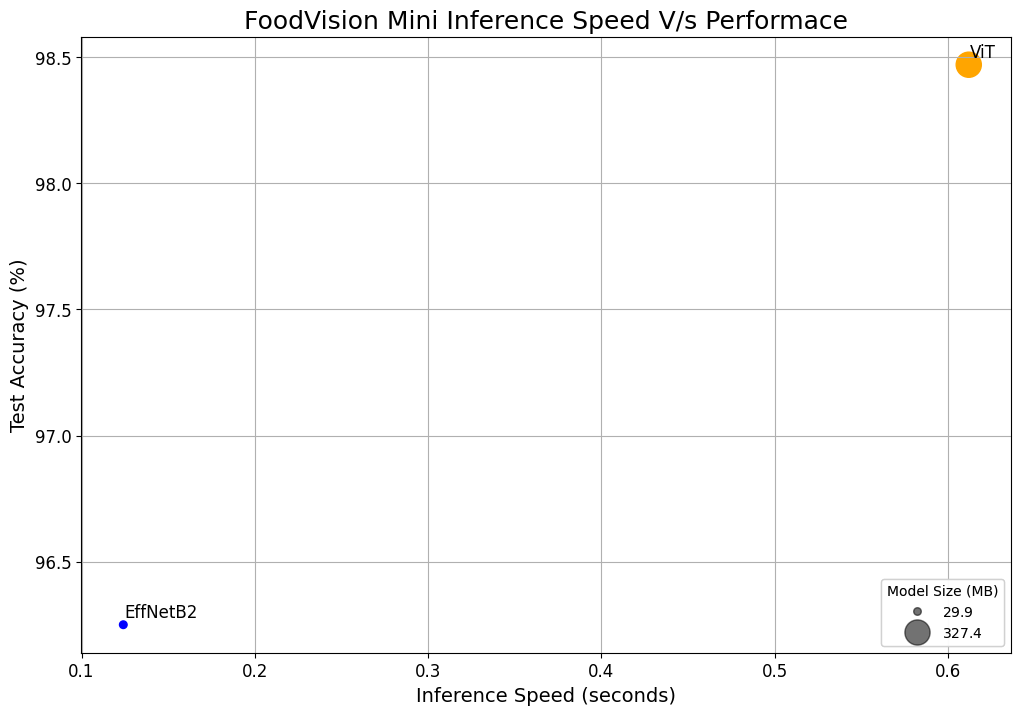

In [ ]:
## Creating a plot from model comparions dataframe
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(data=stats_df,
                     x="avg_time_per_pred",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

## Adding titles and lables
ax.set_title("FoodVision Mini Inference Speed V/s Performace", fontsize=18)
ax.set_xlabel("Inference Speed (seconds)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

## Annotate the samples on the scatter plot
# for index, row in stats_df.iterrows():
#     ax.annotate(s=row["model"],
#                 xy=(row["avg_time_per_pred"] + 0.0006, row["test_acc"] + 0.03),
#                 size=12)

for index, row in stats_df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["avg_time_per_pred"] + 0.0006, row["test_acc"] + 0.03),     ## x and y coordinates
                size=12)

## Create a legend based on the model size (model size (MB))
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
legend = ax.legend(handles, labels, loc="lower right", title="Model Size (MB)")
ax.add_artist(legend)


# Saving the Figure
!mkdir images/
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# Building Gradio Demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
Gradio version: 5.13.1


## Function to Map Input to Output

In [ ]:
from typing import Tuple, Dict

In [ ]:
effnetb2 = effnetb2.to("cpu")

In [ ]:
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
def predict(image) -> Tuple[Dict, float]:
    # Start Timer
    start_time = timer()

    # Transform input image, add batch dim, and move image to cpu
    transformed_image = effnetb2_transforms(image).unsqueeze(0).to("cpu")

    # Put model into eval mode
    effnetb2.eval()

    # Make prediction
    with torch.inference_mode():
        logits = effnetb2(transformed_image)
        pred_probs = torch.softmax(logits, dim=1)

    # Create prediction prob and pred label dict
    pred_probs = torch.softmax(logits, dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # End timer
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # return class and time to compute
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# print(test_data_paths[:3])

random_image_path = random.sample(test_data_paths, k=1)[0]
print(f"Selected Image: {random_image_path}")

image = Image.open(random_image_path)
print(f"Image Ground truth label: {Path(random_image_path).parent.stem}")
pred_dict, pred_time = predict(image)
pred_dict, pred_time

Selected Image: data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg
Image Ground truth label: pizza


({'pizza': 0.9941244721412659,
  'steak': 0.0028508692048490047,
  'sushi': 0.003024691017344594},
 0.1843)

In [ ]:
# Create a list of example inputs to our Gradio demo
# Required format - List[List]
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg']]

In [ ]:
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

In [ ]:
demo = gr.Interface(fn=predict,     # mapping function from input to output
                    inputs=gr.Image(type="pil"),     # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediciton Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

In [ ]:
demo.launch(debug=True,        ## To print errors locally
            share=True)         ## To create a publically sharable link

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a43811cc6575c9c96f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a43811cc6575c9c96f.gradio.live


# Turning FoodVision Mini Gradio Demo into a Deployable App

File structure for FoodVision Mini at Path - `demos/foodvision_mini/`:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [ ]:
import os
import shutil
from pathlib import Path

In [ ]:
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

In [ ]:
# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
! ls demos/foodvision_mini/examples/

2582289.jpg  3622237.jpg  592799.jpg


In [ ]:
# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

In [ ]:
effnetb2_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
foodvision_mini_model_path = foodvision_mini_demo_path / effnetb2_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_model_path} to {foodvision_mini_model_path}")

    # Move the model
    shutil.move(src=effnetb2_model_path,
                dst=foodvision_mini_model_path)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {foodvision_mini_model_path}: {foodvision_mini_model_path.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [ ]:
# Download FoodMini Vision demo App so we can upload it to Hugging Face Spaces
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" ".ipynb" "*__pycache__*" "*ipynb_checkpoints*"  ## -x -- Exclude files from zip

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


In [ ]:
! ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


In [ ]:
# Download
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in google colab, can't use google.colab.files.download(). Download Manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! pwd

/content


In [ ]:
! git clone https://huggingface.co/spaces/Aanchal-S/foodvision_pizza_stake_sushi

Cloning into 'foodvision_pizza_stake_sushi'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (20/20), 170.66 KiB | 11.38 MiB/s, done.


In [ ]:
! cp -r demos/foodvision_mini/* /content/foodvision_pizza_stake_sushi

In [ ]:
!ls /content/foodvision_pizza_stake_sushi

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   README.md
examples								   requirements.txt


In [ ]:
! cd /content/foodvision_pizza_stake_sushi

In [ ]:
! pwd

/content


In [ ]:
!git remote -v

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
! git lfs install
# ! brew install git-lfs        ## If the above code does not work

Git LFS initialized.


In [ ]:
# Track 10MB and larger files with git lfs
! git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
! git lfs track "*.pth"

Not in a git repository.
Not in a git repository.


In [ ]:
! git add .gitattributes

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
! git add *

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
! git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
! git commit -m "initial commit"

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
! git push

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

# Food Vision BIG!!!!

In [ ]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
food_101_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                      effnetb2_transforms])
food_101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
## Getting Data for FoodVision Big
from torchvision import datasets

In [ ]:
# Set up data dir

from pathlib import Path
data_dir = Path("data")

# Gettinf the training data (750 images per class = 750 * 101)
train_data = datasets.Food101(root=data_dir, split="train",
                              transform=food_101_transforms,        ## Applying data augemntation to training data.
                              download=True)

# Getting the testing data (250 images per class = 250 * 101)
test_data = datasets.Food101(root=data_dir, split="test",
                              transform=effnetb2_transforms,        ## No data aug. on test data
                              download=True)

100%|██████████| 5.00G/5.00G [03:49<00:00, 21.8MB/s]


Extracting data/food-101.tar.gz to data


In [ ]:
len(train_data), len(test_data)

(75750, 25250)

In [ ]:
food_101_class_names = train_data.classes
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Creating a subset of food101 dataset for faster experiment (taking 20% of the data)
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [ ]:
# Turning Dataset into dataloader
import os
import torch
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 32

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [ ]:
# Training Food Vision Big!!
from going_modular.going_modular import engine

epochs = 5
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)            ## Regularization technique that adds noise to the labels.

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


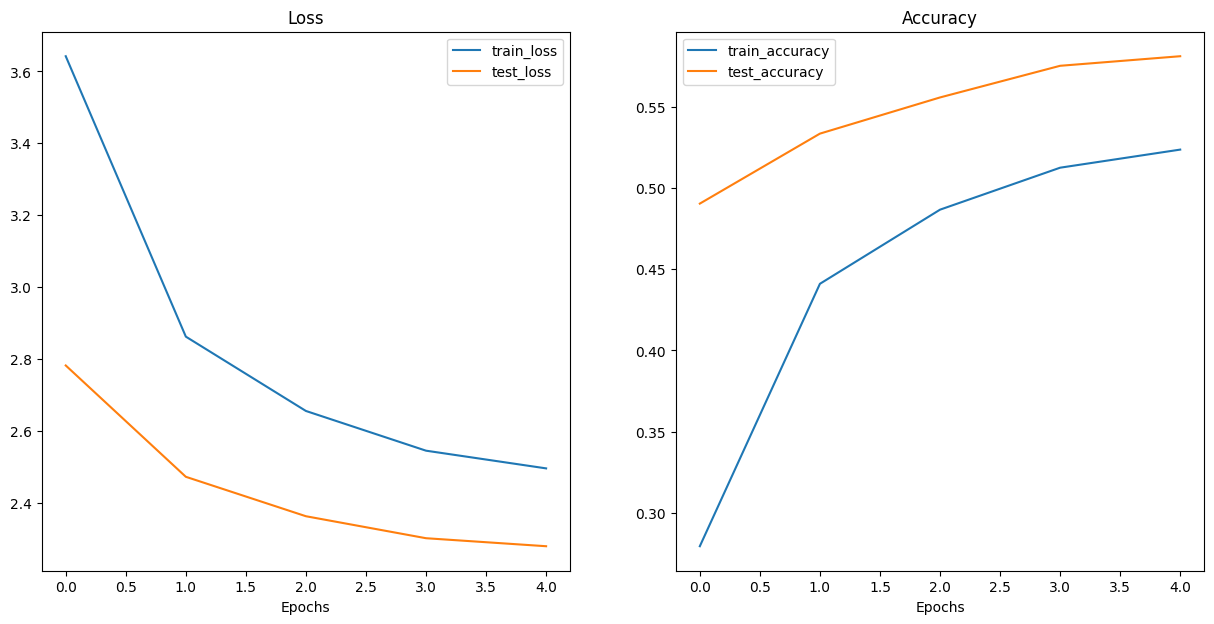

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

In [ ]:
# Saving and loading FoodVision Big

from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<ipython-input-96-b6b0f36a891d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_ex

<All keys matched successfully>

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


### Turning the FoodVision Big Model into a Deployable App

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt

```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [ ]:
# Downloading an example image and moving it to the examples directory

!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-01-28 03:58:46--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2025-01-28 03:58:46 (49.1 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [ ]:
# Saving Food101 class names to file (class_names.txt)

food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food_101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

#### Turning our FoodVision Big model into a Python script (model.py)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


#### Turning our FoodVision Big Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


In [ ]:
# Creating a requirements file for FoodVision Big (requirements.txt)
%%writefile demos/foodvision_big/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.13.1

Writing demos/foodvision_big/requirements.txt


#### Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Embedding the HuggingFace Space in the Colab Notebook

In [ ]:
# IPython is a library to help work with Python interactively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_big/+", width=900, height=750)